In [1]:
# First, do the following

# scripts/generate_reactions
# scripts/build_reactions database/reactions/eclogite_slb_rx.rxml

In [2]:
import os,sys
import pandas as pd
import numpy as np
import sympy as sym
import time
import re
import types
import ast
import sys
sym.init_printing()
sys.path.append(os.path.join(os.path.pardir, 'python'))

from tcg_slb.reactions import SLBReactions

#pd.set_option("display.max_columns", None)
#pd.set_option("display.max_rows", None)

In [3]:
dbfile = os.path.abspath(os.path.join(os.path.pardir, 'database', 'tcg_slb_database.tar.gz'))
dbpath = "file://{}".format(dbfile)
dbpath

'file:///workspaces/tcg-ec/systems/ec/database/tcg_slb_database.tar.gz'

In [4]:
reference= 'ec_reactions' 

In [5]:
phases = ['Quartz_slb_ph', 'Albite_slb_ph', 'Jadeite_slb_ph', 'Garnet_slb_ph'] # water?

reactions = []

reactions.append((
    [['Jadeite_slb_ph', 'Jadeite_slb_em'], ['Quartz_slb_ph', 'Quartz_slb_em']],
    [['Albite_slb_ph', 'Albite_slb_em']]
))

reactions.append((
    [['Garnet_slb_ph', 'NaMajorite_slb_em'], ['Quartz_slb_ph', 'Quartz_slb_em']],
    [['Albite_slb_ph', 'Albite_slb_em']]
))

reactions.append((
    [['Jadeite_slb_ph', 'Jadeite_slb_em']],
    [['Garnet_slb_ph', 'NaMajorite_slb_em']]
))

slbrxn = SLBReactions('ec_slb_all_rn',
                       len(reactions), phases, dbpath, reference)

for reaction in reactions: slbrxn.add_reaction(*reaction)

Overriding T0 -- already exists in model_dict
Overriding R -- already exists in model_dict
Overriding T0 -- already exists in model_dict
Overriding R -- already exists in model_dict


In [6]:
slbrxn.params() 

[('T0', 'K', T0), ('R', 'J/mol/K', R)]

In [7]:
slbrxn.values_dict()

{'name': 'ec_slb_all_rn',
 'reference': 'ec_reactions',
 'T0': 2000.0,
 'R': 8.31446261815324}

In [8]:
import sys, os
import numpy as np

sys.path.append(os.path.join(os.path.pardir, 'python'))
from tcg_slb.phasediagram.scipy import ScipyPDReactiveODE
from tcg_slb.phasediagram.base import PDReactiveGrid, PDReactiveGridDiagnostics
from tcg_slb.base import *


scipy available


In [9]:
pv = repr(sys.version_info.major)+'.'+repr(sys.version_info.minor)
newpath = os.path.join(os.path.pardir, 'database', 'install', 'eclogite_slb_rx', 'lib', 'python'+pv, 'site-packages/') # the final slash is necessary!
print(newpath)
sys.path.append(newpath)
import py_eclogite_slb_rx as tcgdb
rxn = tcgdb.eclogite_slb_rx()
rxn.report()

../database/install/eclogite_slb_rx/lib/python3.8/site-packages/
Reaction object: eclogite_slb_rx

Phase 0 Jadeite_slb_ph (jd)
     Endmember 0 Jadeite_slb_em : NaAlSi2O6_(jd)
Phase 1 Quartz_slb_ph (qtz)
     Endmember 0 Quartz_slb_em : SiO2_(qtz)
Phase 2 Albite_slb_ph (ab)
     Endmember 0 Albite_slb_em : NaAlSi3O8_(ab)
Phase 3 Garnet_slb_ph (gt)
     Endmember 0 Pyrope_slb_em : Mg3Al2Si3O12_(gt)
     Endmember 1 Almandine_slb_em : Fe3Al2Si3O12_(gt)
     Endmember 2 Grossular_slb_em : Ca3Al2Si3O12_(gt)
     Endmember 3 MgMajorite_slb_em : Mg4Si4O12_(gt)
     Endmember 4 NaMajorite_slb_em : Na2Al2Si4O12_(gt)

Reaction 0
     0.5 NaAlSi2O6_(jd) + 0.5 SiO2_(qtz) -> 0.5 NaAlSi3O8_(ab)
Reaction 1
     0.666667 SiO2_(qtz) + 0.333333 Na2Al2Si4O12_(gt) -> 0.666667 NaAlSi3O8_(ab)
Reaction 2
     NaAlSi2O6_(jd) -> 0.5 Na2Al2Si4O12_(gt)


In [10]:
ode = ScipyPDReactiveODE(rxn) 

In [11]:
# initial temperature, pressure and phase volume fraction
Ti = 900.                # Kelvin
pi = GPa2Bar(10.)         # bars

In [12]:
mi0 = np.asarray([0.0, 0.4, 0.25, 0.35]) # initial phase comps

Cik0 = np.zeros(ode.K) # initial endmember comps
for i in range(ode.I):
    j1 = sum(ode.Kis[:i])
    j2 = sum(ode.Kis[:i+1])
    nEndmembers = ode.Kis[i]
    if nEndmembers == 1:
        Cik0[j1:j2] = 1.
    else:
        Cik0[j1:j2][:nEndmembers] = np.ones(nEndmembers)/nEndmembers
        
display(mi0)
display(Cik0)

array([0.  , 0.4 , 0.25, 0.35])

array([1. , 1. , 1. , 0.2, 0.2, 0.2, 0.2, 0.2])

In [13]:
ode.solve(Ti,pi,mi0,Cik0,1000.0) # T, p, mi0, Cik0, Tend, **kwargs


In [14]:
ode.stime 

In [15]:
ode.final_phases(1.e-2)

(array(['Jadeite_slb_ph', 'Quartz_slb_ph', 'Garnet_slb_ph'], dtype='<U14'),
 array(['jd', 'qtz', 'gt'], dtype='<U3'))

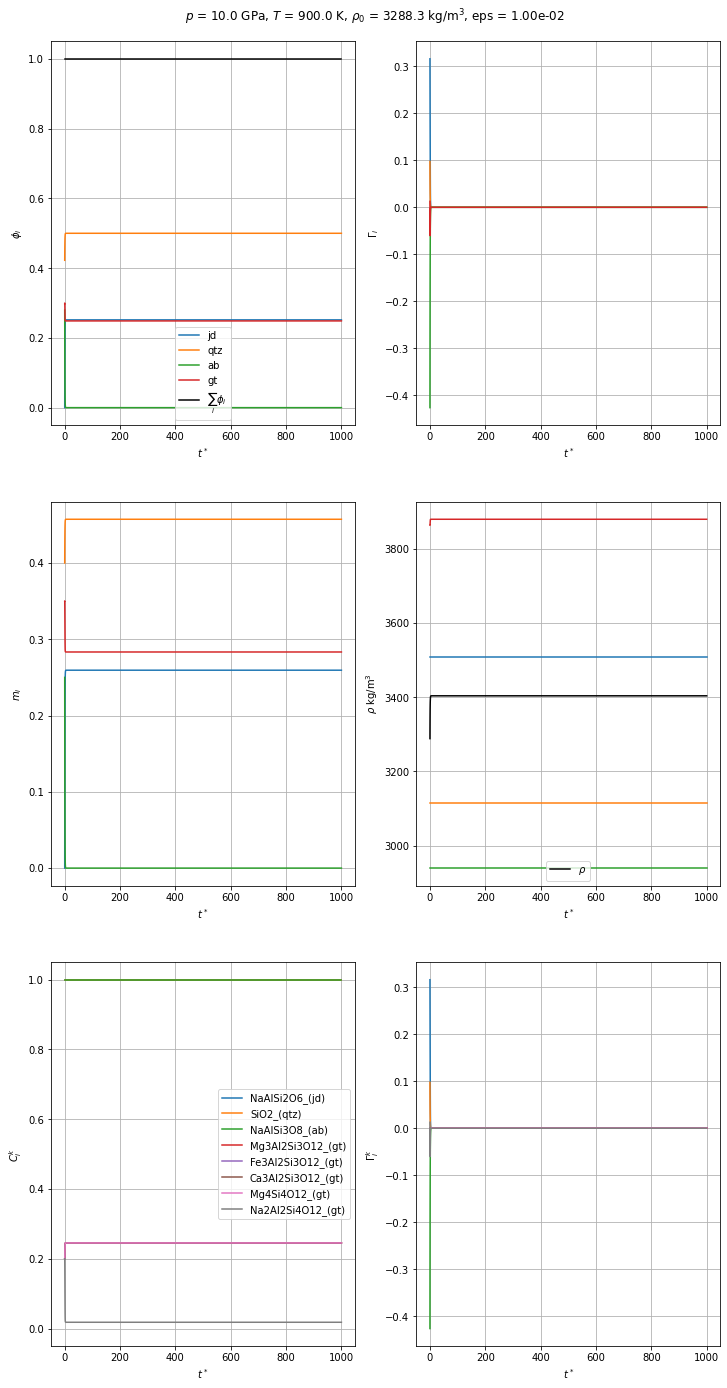

In [16]:
ode.plot() 

In [40]:
reload = False

import pickle

filename = os.path.join('output', 'scipy_bdfgrid_eclogite.pickle')

i0 = 2
p_n = 50
p_min = 0.0
p_max = 5.0
Dp = p_max - p_min
p_range = np.linspace(p_min+0.5*Dp/p_n, p_max-0.5*Dp/p_n, p_n)
T_n = 50
T_min = 0.
T_max = 1200.
DT = T_max - T_min
T_range = np.linspace(T_min+0.5*DT/T_n, T_max-0.5*DT/T_n, T_n)
end = 1e5

if reload:
    pfile = open(filename, 'rb')
    bdfgrid = pickle.load(pfile)
    pfile.close()
else:
    bdfgrid = PDReactiveGrid()
    bdfgrid.solve(rxn, ScipyPDReactiveODE, i0, ['p', 'T'], p_range, T_range, end, **{'Cik0':Cik0})

In [41]:
save = False

if not reload and save:
    pfile = open(filename, 'wb+')
    pickle.dump(bdfgrid, pfile)
    pfile.close()

In [42]:
import matplotlib.pyplot as plt

def decorate(pdrgd):
    def new_setup_axes(self,axi):
        axi.axis('off')
        ax = axi.inset_axes([0.001,0.005,0.998,0.993])
        ax.patch.set_alpha(0.0)
        ax.set_xlim([p_min, p_max])
        ax.set_xlabel("Pressure (GPa)")

        ax.set_ylim([T_min, T_max])
        ax.set_ylabel("Temperature (K)")

        return ax
    
    #replace the display with newdisplay
    pdrgd.setup_axes = new_setup_axes
    
    #return the modified student 
    return pdrgd

bdfdiag = decorate(PDReactiveGridDiagnostics)(rxn,bdfgrid) 

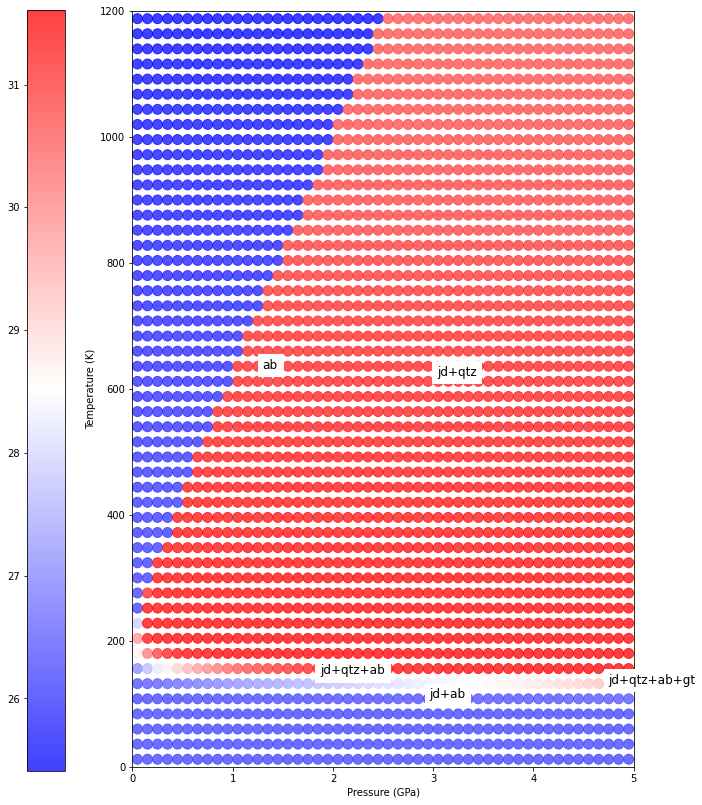

In [43]:
bdfdiag.plot_rho() 

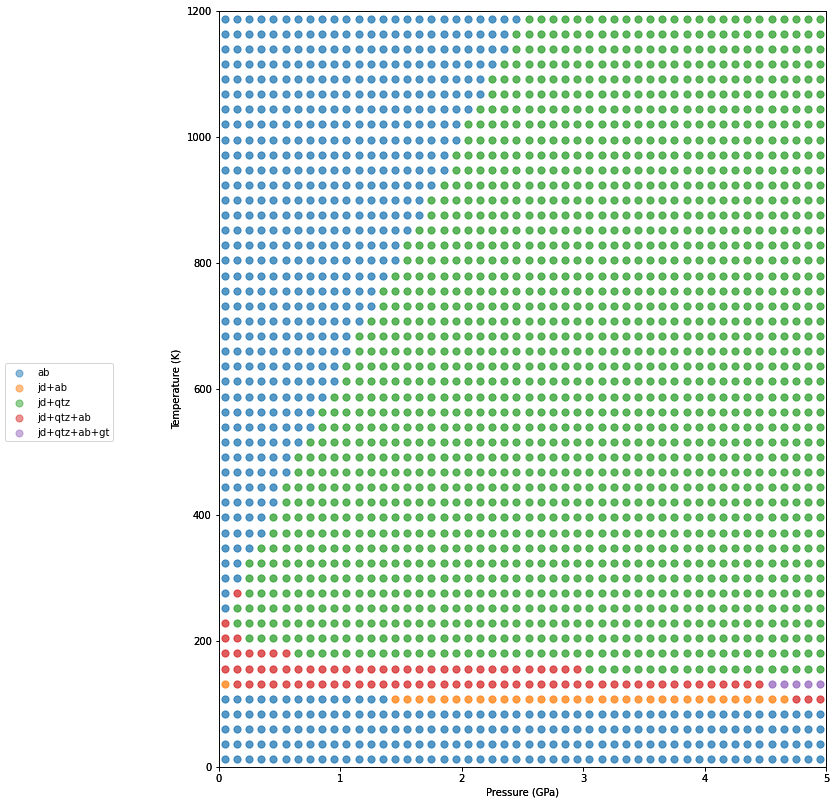

In [21]:
#%matplotlib widget
bdfdiag.plot_phases()